In [1]:
import numpy as np
import pandas as pd
import os

In [7]:
file = 'data_prepocessed/海康威视_002415_成长.xlsx'
df = pd.read_excel(file)
df.head()

,Unnamed: 0,股价,前收盘价(元),开盘价(元),最高价(元),最低价(元),收盘价(元),成交量(股),成交金额(元),涨跌(元),...,宏观_PPI,宏观_出口价格指数(总),宏观_出口价格指数(车船航),宏观_进口价格指数(总),宏观_进口价格指数(车船航),宏观_固定资产投资完成额,宏观_社会消费品零售总额,宏观_M2,宏观_金融机构各项贷款余额,宏观_社会融资规模
0,2016-01-08,29.25,-0.606953,-0.507542,-0.506968,-0.588521,-0.515301,-0.929499,-0.977194,1.165927,...,-5.3,93.9,99.3,86.9,102.1,0.0,0.0,14.0,15.3,34758.0
1,2016-01-11,28.93,-0.515462,-0.547978,-0.530519,-0.657445,-0.679977,-0.907597,-0.973743,-2.140483,...,-5.3,93.9,99.3,86.9,102.1,0.0,0.0,14.0,15.3,34758.0
2,2016-01-12,28.51,-0.680146,-0.635589,-0.668062,-0.676154,-0.710794,-0.986151,-1.050495,-0.412697,...,-5.3,93.9,99.3,86.9,102.1,0.0,0.0,14.0,15.3,34758.0
3,2016-01-13,29.36,-0.710964,-0.672174,-0.703861,-0.726370,-0.751241,-1.180293,-1.198319,-0.536998,...,-5.3,93.9,99.3,86.9,102.1,0.0,0.0,14.0,15.3,34758.0
4,2016-01-14,28.29,-0.751412,-0.798296,-0.709513,-0.785448,-0.669384,-0.914004,-1.011334,1.041625,...,-5.3,93.9,99.3,86.9,102.1,0.0,0.0,14.0,15.3,34758.0


In [226]:
import torch
import torch.nn as nn

def normalize(data):
    return (data - data.mean(0)) / data.std(0)

def construct_dataset(data, interval=0):
    n = len(data)
    dataset = torch.Tensor()
    for i in range(n-interval-1):
        dataset = torch.cat([dataset, data[i:i+interval+1].unsqueeze(0)], 0)
    return dataset
#     return data.unsqueeze(1)
    
def split_data(data, split_ratio):
    return data[:int(split_ratio*len(data))], data[int(split_ratio*len(data)):]

def split_x_y(data):
    return data[:, :, 1:], data[:, :, 0]

train_val_split = 0.8
data = torch.Tensor(df.to_numpy()[:, 1:].astype(np.float32))
data = normalize(data)
train_data, val_data = split_data(data, train_val_split)
train_set, val_set = construct_dataset(train_data), construct_dataset(val_data)
train_x, train_y = split_x_y(train_set)
val_x, val_y = split_x_y(val_set)

In [236]:
input_dim = 49
hidden_dim = 32
num_layers = 2
output_dim = 1

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).cuda()
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(500):
    inputs, targets = train_x.cuda(), train_y.cuda()
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()   
    
    if epoch % 100 == 0:
        inputs, targets = val_x.cuda(), val_y.cuda()
        outputs = model(inputs)
        test_loss = loss_fn(outputs, targets)
        print(f"Epoch: {epoch}, Train Loss: {loss.item()}, Val Loss: {test_loss.item()}")

Epoch: 0, Train Loss: 0.9144237041473389, Val Loss: 1.2450098991394043
Epoch: 100, Train Loss: 0.0073222815990448, Val Loss: 0.7131860256195068
Epoch: 200, Train Loss: 0.004884183872491121, Val Loss: 0.16627100110054016
Epoch: 300, Train Loss: 0.00354071450419724, Val Loss: 0.1336207091808319
Epoch: 400, Train Loss: 0.0025117776822298765, Val Loss: 0.15556974709033966


torch.Size([1341])


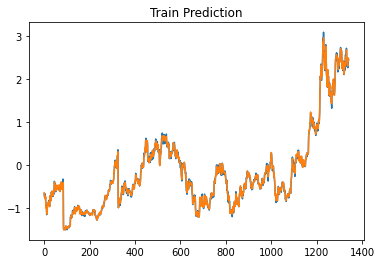

In [237]:
inputs, targets = train_x.cuda(), train_y.cuda()
outputs = model(inputs).cpu().squeeze().detach()
print(outputs.shape)

plt.title('Train Prediction')
plt.plot(targets.cpu())
plt.plot(outputs)
plt.show()

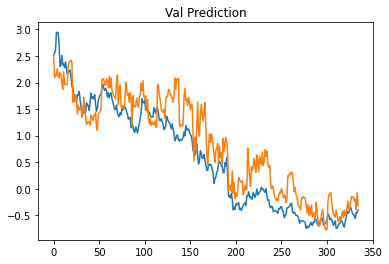

In [238]:
from matplotlib import pyplot as plt

inputs, targets = val_x.cuda(), val_y.cuda()
outputs = model(inputs).cpu().squeeze().detach()

plt.title('Val Prediction')
plt.plot(targets.cpu())
plt.plot(outputs)
plt.show()